In [2]:
cd ..

/home/bpandey/kernels


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from estimator import RFClassifier, relu
from data_fns import data_matrix_non_ov, butter_bandpass_filter
import dask

In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:43331 Dashboard: http://127.0.0.1:41455/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [130]:
def mixed_sinusoids(f_s=2000, dur=10, f_signal=40, f_noise=[90, 120], sig_dur=0.05, seed=None):
    
    np.random.seed(seed)

    if a < 0 or a > 1:
        raise ValueError('a should be between 0 and 1')
    n_amp = np.sqrt(1 - a ** 2) 

    t_points = np.arange(0, dur, 1/f_s)
    t_series = np.sum([np.sin(2 * np.pi * f * t_points) for f in 
                       np.random.randint(90, 120, 5)], axis=0) / 5 # mixture of sine waves
    label = np.zeros(len(t_series))

    d = int(sig_dur * f_s) # array len of signal
    p = np.arange(0, len(t_points), d) # array with points d apart
    idx = np.random.choice(p, int(dur / (2 * sig_dur)), replace=False)
    for i in idx:
        t = t_points[i:i + d]
        t_series[i:i + d] = np.sin(2 * np.pi * f_signal * t) / 2
        label[i:i + d] = 1
    return t_series, label

In [131]:
def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [132]:
signal, label = mixed_sinusoids(f_s=2000, dur=900, f_signal=40, f_noise=[90, 120], sig_dur=0.05)
# signal, label = mixed_sinusoids(f_s=3000, dur=900, f_signal=[40, 90], sig_dur=0.05, a=1)

delta = 0.07
N = int(delta * 2000)
X, y = data_matrix_non_ov(signal, label, N)
idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

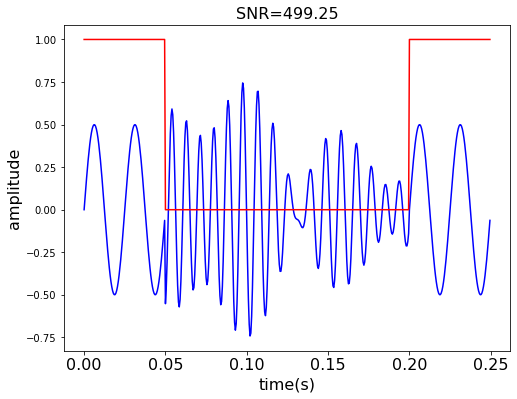

In [136]:
t = np.arange(0, 500, 1/2000)
fig = plt.figure(figsize=(8, 6))
plt.title('SNR=%0.2f' % snr, fontsize=16)
plt.plot(t[:500], signal[:500], 'b')
plt.plot(t[:500], label[:500], 'r')
plt.xlabel('time(s)', fontsize=16)
plt.ylabel('amplitude', fontsize=16)
plt.xticks(fontsize=16)
plt.savefig('figures/rand_classification/non_ov_windows/mixed_sin_sig/sin_noise_sig.png')

In [139]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


In [140]:
%%time
# gaussian features
results_gaus= []
for n in n_features:
    params = {'width': n, 'weights': 'unimodal', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_gaus.append(dask.compute(*lazy_results))
    
mean_gaus = 1 - np.mean(results_gaus, axis=1)
std_gaus = np.std(results_gaus, axis=1)

CPU times: user 9.14 s, sys: 5.24 s, total: 14.4 s
Wall time: 38.8 s


In [141]:
%%time 
# white noise features
results_whitenoise = []
for n in n_features:
    params = {'width': n, 'weights': 'white noise', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_whitenoise.append(dask.compute(*lazy_results))

mean_whitenoise = 1 - np.mean(results_whitenoise, axis=1)
std_whitenoise = np.std(results_whitenoise, axis=1)

CPU times: user 10.1 s, sys: 5.46 s, total: 15.6 s
Wall time: 47.8 s


In [142]:
%%time 
f = lambda M, N: bp_weights(M, N, lowcut=20, highcut=70, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))

mean_bp = 1 - np.mean(results_bp, axis=1)
std_bp = np.std(results_bp, axis=1)

CPU times: user 8.69 s, sys: 5.45 s, total: 14.1 s
Wall time: 42.8 s


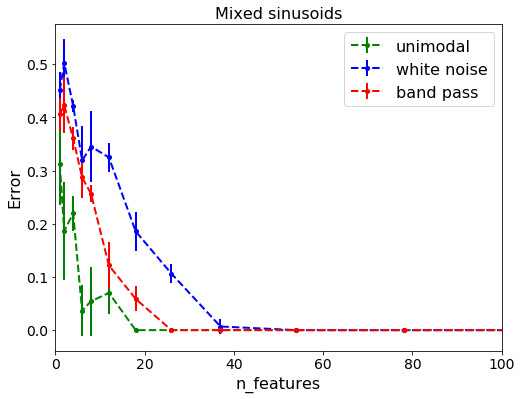

In [143]:
# plot
# snr = a ** 2 / (1 - a ** 2)
fig = plt.figure(figsize=(8, 6))
plt.title('Mixed sinusoids', fontsize=16)
plt.errorbar(n_features, mean_gaus, yerr=std_gaus, fmt='--go', label='unimodal', markersize=4, lw=2)
plt.errorbar(n_features, mean_whitenoise, yerr=std_whitenoise, fmt='--bo', label='white noise', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp, yerr=std_bp, fmt='--ro', label='band pass', markersize=4, lw=2)
plt.legend(fontsize=16)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 100)
plt.savefig('figures/rand_classification/non_ov_windows/mixed_sin_sig/clf_sin_noise_sig.png')

In [87]:
def mixed_sinusoids(f_s=2000, dur=10, f_signal=[40, 90], sig_dur=0.05, a=1, seed=None):
    '''
    Generate a time series of random noise interspersed with periods where a sinusoidal signal is on
    
    Parameters
    ----------
    
    f_s = sampling frequency (Hz)
    dur = duration of the time series (s)
    f_signal = frequency of the signal (Hz)
    sig_dur = duration of the signal (s)
    a: 2x amplitude of the signal used for snr (between 0 and 1)
    if n_amp = 2 x noise_amplitude: a ** 2 + n_amp ** 2 = 1; snr = a**2/n_amp**2
    
    Returns
    -------
    time_series: an array of shape (f_s * dur, 1)
    labels: array with binary values (0, 1) shape (f_s * dur, )
    '''
    if seed is not None:
        np.random.seed(seed)
    
    if a < 0 or a > 1:
        raise ValueError('a should be between 0 and 1')
    n_amp = np.sqrt(1 - a ** 2) 
    
    t_points = np.arange(0, dur, 1/f_s)
    t_series = np.random.normal(0, 1, dur * f_s)
    label = np.zeros(len(t_series))
    
    d = int(sig_dur * f_s) # array len of signal
    p = np.arange(0, len(t_points), d) # array with points d apart
    idx = np.random.choice(p, int(dur / (2 * sig_dur)), replace=False)
    for i in idx:
        t = t_points[i:i + d]
        sig = np.sum([np.sin(2 * np.pi * f * t) for f in np.random.randint(f_signal[0], f_signal[1], 5)], axis=0)
        t_series[i:i + d] = (np.sqrt(2/5) * a  * sig) + n_amp * np.random.randn(len(t))
        label[i:i + d] = 1
    return t_series, label

In [114]:
mkdir figures/rand_classification/non_ov_windows/mixed_sin_sig

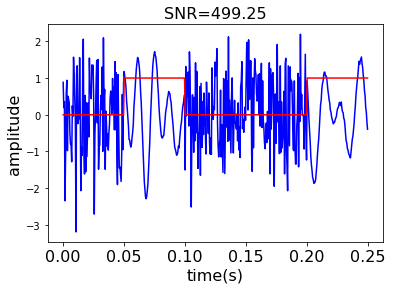

In [120]:
a = 0.999
signal, label = mixed_sinusoids(f_s=2000, dur=500, f_signal=[40, 90], sig_dur=0.05, a=a, seed=20)

delta = 0.07
N = int(delta * 2000)
X, y = data_matrix_non_ov(signal, label, N)
idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

snr = a ** 2 / (1 - a ** 2)
t = np.arange(0, 500, 1/2000)
plt.title('SNR=%0.2f' % snr, fontsize=16)
plt.plot(t[:500], signal[:500], 'b')
plt.plot(t[:500], label[:500], 'r')
plt.xlabel('time(s)', fontsize=16)
plt.ylabel('amplitude', fontsize=16)
plt.xticks(fontsize=16)
plt.savefig('figures/rand_classification/non_ov_windows/mixed_sin_sig/sig_a=%0.2f.png' % a)

In [121]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


In [122]:
%%time
# gaussian features
results_gaus= []
for n in n_features:
    params = {'width': n, 'weights': 'unimodal', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_gaus.append(dask.compute(*lazy_results))
    
mean_gaus = 1 - np.mean(results_gaus, axis=1)
std_gaus = np.std(results_gaus, axis=1)

CPU times: user 10.1 s, sys: 3.27 s, total: 13.4 s
Wall time: 54.3 s


In [123]:
%%time 
# white noise features
results_whitenoise = []
for n in n_features:
    params = {'width': n, 'weights': 'white noise', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_whitenoise.append(dask.compute(*lazy_results))

mean_whitenoise = 1 - np.mean(results_whitenoise, axis=1)
std_whitenoise = np.std(results_whitenoise, axis=1)

CPU times: user 8.83 s, sys: 2.94 s, total: 11.8 s
Wall time: 46.8 s


In [127]:
%%time 
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=80, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))

mean_bp = 1 - np.mean(results_bp, axis=1)
std_bp = np.std(results_bp, axis=1)

CPU times: user 9.08 s, sys: 3.15 s, total: 12.2 s
Wall time: 48.1 s


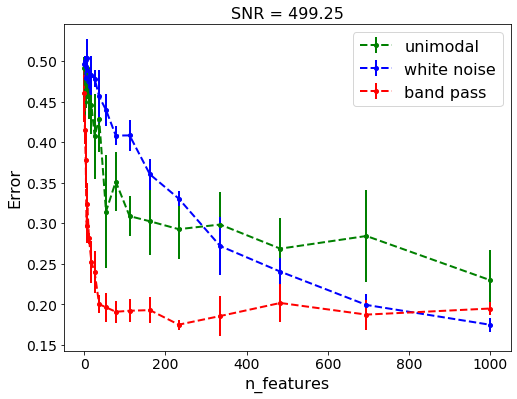

In [129]:
# plot
snr = a ** 2 / (1 - a ** 2)
fig = plt.figure(figsize=(8, 6))
plt.title('SNR = %0.2f' % snr, fontsize=16)
plt.errorbar(n_features, mean_gaus, yerr=std_gaus, fmt='--go', label='unimodal', markersize=4, lw=2)
plt.errorbar(n_features, mean_whitenoise, yerr=std_whitenoise, fmt='--bo', label='white noise', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp, yerr=std_bp, fmt='--ro', label='band pass', markersize=4, lw=2)
plt.legend(fontsize=16)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim(0, 100)
plt.savefig('figures/rand_classification/non_ov_windows/mixed_sin_sig/clf_a=%0.2f.png' % a)